In [1]:
total_files = 60
#Fabric Spark expect the path in this format
raw_landing='/lakehouse/default/Files/something'
table_root = '/lakehouse/default/Tables/'

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 3, Finished, Available, Finished)

***Check if Fabric running***

In [2]:
# @title
## if running inside Fabric, it will skip Spark installation
try:
    mssparkutils
except NameError:
    mssparkutils = None

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 4, Finished, Available, Finished)

***Install Package***

In [3]:
!pip install   duckdb  --upgrade
!pip install   polars  --pre --upgrade
!pip install   'ibis-framework' --upgrade
!pip install   deltalake==0.17.4
!pip install   getdaft

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 5, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 127.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 92.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 103.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 98.9 MB/s eta 0:00:00:00:0100:01


In [4]:
if mssparkutils is None:
 !pip install  delta-spark
 import pyspark
 from delta import *
 builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
 spark = configure_spark_with_delta_pip(builder).getOrCreate()
 spark.conf.set("spark.sql.execution.arrow.enabled", "true")
else:
 print('You are in Fabric, all good, no need to install Spark')


StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 6, Finished, Available, Finished)

You are in Fabric, all good, no need to install Spark


In [5]:
# @title
from psutil import *
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 7, Finished, Available, Finished)

8 vCPU Memory:63.0


# Download Data

In [6]:
# @title
import re ,os
import requests
from urllib.request import urlopen
def download(url,Path):
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True)
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = list(set(filelist1))[:total_files]
    print(str(len(filelist_unique)) + ' New File Loaded')
    if len(filelist_unique) != 0 :
      for x in filelist_unique:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}/{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)
    return "done"

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 8, Finished, Available, Finished)

In [7]:
# @title
from shutil import unpack_archive
import os , glob
def unzip(Source, Destination):
    filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    for x in filelist:
          try:
            unpack_archive(str(Source+x), str(Destination), 'zip')
          except:
            pass
    return "done"

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 9, Finished, Available, Finished)

In [8]:
#download("https://nemweb.com.au/Reports/Current/Daily_Reports/",raw_landing+"/zip/")
#unzip(raw_landing+"/zip/",raw_landing+"/csv/")

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 10, Finished, Available, Finished)

# DuckDB

In [9]:
# @title
import duckdb
def duckdb_clean_csv(x):
	raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)
	columns = list(set(raw.columns) - {'SETTLEMENTDATE','DUID','I','filename','UNIT'})
	exprs = [
		duckdb.ColumnExpression(x).cast(duckdb.typing.DOUBLE).alias(x)
		for x in columns
	         ]
	rel2 = raw.select('SETTLEMENTDATE','DUID','I','filename','UNIT',*exprs)

	scada=duckdb.sql(""" select *exclude(SETTLEMENTDATE,I,XX,filename),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as YEAR  from rel2  """)
	return scada.arrow()


StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 11, Finished, Available, Finished)

# Polars

In [10]:
# @title
import polars as pl
def polars_clean_csv(x):
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x,
                    skip_rows=1,
                    schema=schema,
                    has_header=False,
                    truncate_ragged_lines=True)
  transform =(
      raw
      .filter(pl.col("I")=='D')
      .filter(pl.col("UNIT")=='DUNIT')
      .filter(pl.col("VERSION")=='3')
      .drop("XX")
      .drop("I")
  )
  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.collect_schema().names()) - {'SETTLEMENTDATE','DUID','UNIT'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),YEAR=pl.col("SETTLEMENTDATE").dt.iso_year()).collect()
  return final.to_arrow()

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 12, Finished, Available, Finished)

# Pandas

In [11]:
import pandas as pd

def Pandas_clean_csv(chunk):
    appended_data = []
    for filename in chunk:
        # Read only necessary columns
        df = pd.read_csv(filename, skiprows=1,dtype=str, names=range(131), keep_default_na=False,  index_col=False)
        df = df.iloc[:, :53]
        df = df.rename(columns={1: 'DISPATCH', 3: 'VERSION'}).query('DISPATCH=="DUNIT" and VERSION=="3"')
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'3': 'version', 'DUNIT': 'UNIT'})
        df = df.drop(columns=['I'])
        df.drop([""], axis=1, inplace=True)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        columns = list(set(df.columns) - {'SETTLEMENTDATE', 'DUID', 'UNIT'})
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce', dtype_backend='pyarrow')
        df['YEAR'] = df['SETTLEMENTDATE'].dt.year
        appended_data.append(df)
    appended_data = pd.concat(appended_data, ignore_index=True)
    return appended_data

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 13, Finished, Available, Finished)

# Spark

In [12]:
# @title
from pyspark.sql import functions as f
def spark_clean_csv(files_to_upload_full_Path):
 user_schema="""
 I  STRING,UNIT  STRING,XX  STRING,VERSION  STRING,SETTLEMENTDATE  STRING,RUNNO  STRING,DUID  STRING,
 INTERVENTION  STRING,DISPATCHMODE  STRING,AGCSTATUS  STRING,INITIALMW  STRING,TOTALCLEARED  STRING,RAMPDOWNRATE  STRING,
 RAMPUPRATE  STRING,LOWER5MIN  STRING,LOWER60SEC  STRING,LOWER6SEC  STRING,RAISE5MIN  STRING,RAISE60SEC  STRING,RAISE6SEC  STRING,
 MARGINAL5MINVALUE  STRING,MARGINAL60SECVALUE  STRING,MARGINAL6SECVALUE  STRING,MARGINALVALUE  STRING,VIOLATION5MINDEGREE  STRING,
 VIOLATION60SECDEGREE  STRING,VIOLATION6SECDEGREE  STRING,VIOLATIONDEGREE  STRING,LOWERREG  STRING,RAISEREG  STRING,AVAILABILITY  STRING,
 RAISE6SECFLAGS  STRING,RAISE60SECFLAGS  STRING,RAISE5MINFLAGS  STRING,RAISEREGFLAGS  STRING,LOWER6SECFLAGS  STRING,LOWER60SECFLAGS STRING,
 LOWER5MINFLAGS  STRING,LOWERREGFLAGS  STRING,RAISEREGAVAILABILITY  STRING,RAISEREGENABLEMENTMAX  STRING,RAISEREGENABLEMENTMIN  STRING,
 LOWERREGAVAILABILITY  STRING,LOWERREGENABLEMENTMAX  STRING,LOWERREGENABLEMENTMIN  STRING,RAISE6SECACTUALAVAILABILITY  STRING,
 RAISE60SECACTUALAVAILABILITY  STRING,RAISE5MINACTUALAVAILABILITY  STRING,RAISEREGACTUALAVAILABILITY  STRING,
 LOWER6SECACTUALAVAILABILITY  STRING,LOWER60SECACTUALAVAILABILITY  STRING,LOWER5MINACTUALAVAILABILITY  STRING,
 LOWERREGACTUALAVAILABILITY  STRING
 """
 df = spark.read.format("csv")\
     .option("header","true") \
     .schema(user_schema)\
     .load(files_to_upload_full_Path)\
     .filter("unit='DUNIT' and version =3 and I='D'")\
     .drop('xx')\
     .drop('I')\
     .withColumn('SETTLEMENTDATE',f.to_timestamp('SETTLEMENTDATE','yyyy/MM/dd HH:mm:ss'))\
     .withColumn("file", f.regexp_extract(f.input_file_name(), r"Daily_Reports\/([^\W'\.']+\.CSV)", 1))\
     .withColumn("PRIORITY", f.lit(1))
 df_cols = list(set(df.columns) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY'})
 for col_name in df_cols:
    df = df.withColumn(col_name, f.col(col_name).cast('double'))
 df = df.withColumn('DATE', f.to_date(f.col('SETTLEMENTDATE')))\
      .withColumn('YEAR', f.year(f.col('SETTLEMENTDATE')))
 return df

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 14, Finished, Available, Finished)

# Ibis

In [13]:
# @title
import ibis
def ibis_clean_csv(files_to_upload_full_Path):
 schema={
			'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
			'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
			'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
			'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
			'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
			'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
			'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
			'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
			'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
			'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
			'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
			'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
			'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
			'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
			'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
			'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'}
 raw = ibis.read_csv(files_to_upload_full_Path,Skip=1,header =0,all_varchar=1,columns =schema,filename =1,null_padding = 1,ignore_errors=1,auto_detect=0)
 DUNIT = raw.filter((raw.UNIT == "DUNIT") & (raw.VERSION  == '3') & (raw.I  == 'D')).drop("XX","I")
 DUNIT = DUNIT.cast({"SETTLEMENTDATE": "timestamp"})
 DUNIT = DUNIT.mutate(
      date=DUNIT.SETTLEMENTDATE.cast("date"),
      year=DUNIT.SETTLEMENTDATE.year(),
  )
 df_cols = list(set(DUNIT.columns) - {'SETTLEMENTDATE','DUID','filename','UNIT','date','year'})
 DUNIT = DUNIT.cast({col_name: "double" for col_name in df_cols})
 return DUNIT

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 15, Finished, Available, Finished)

# Pyarrow

In [14]:
# work in Progress
from pyarrow import csv
import pyarrow.compute as pc
import pyarrow as pa
import pyarrow.dataset as ds
def pyarrow_clean_csv(files_to_upload_full_Path):
  new_schema = pa.schema([
  ('I', pa.string()),  ('UNIT', pa.string()),  ('XX', pa.string()),  ('VERSION', pa.float64()),  ('SETTLEMENTDATE', pa.string()),  ('RUNNO', pa.float64()),  ('DUID', pa.string()),  ('INTERVENTION', pa.float64()),
  ('DISPATCHMODE', pa.float64()),  ('AGCSTATUS', pa.float64()),  ('INITIALMW', pa.float64()),  ('TOTALCLEARED', pa.float64()),  ('RAMPDOWNRATE', pa.float64()),  ('RAMPUPRATE', pa.float64()),  ('LOWER5MIN', pa.float64()),
  ('LOWER60SEC', pa.float64()),  ('LOWER6SEC', pa.float64()),  ('RAISE5MIN', pa.float64()),  ('RAISE60SEC', pa.float64()),  ('RAISE6SEC', pa.float64()),  ('MARGINAL5MINVALUE', pa.float64()),  ('MARGINAL60SECVALUE', pa.float64()),
  ('MARGINAL6SECVALUE', pa.float64()),  ('MARGINALVALUE', pa.float64()),  ('VIOLATION5MINDEGREE', pa.float64()),  ('VIOLATION60SECDEGREE', pa.float64()),  ('VIOLATION6SECDEGREE', pa.float64()),  ('VIOLATIONDEGREE', pa.float64()),
  ('LOWERREG', pa.float64()),  ('RAISEREG', pa.float64()),  ('AVAILABILITY', pa.float64()),  ('RAISE6SECFLAGS', pa.float64()),  ('RAISE60SECFLAGS', pa.float64()),  ('RAISE5MINFLAGS', pa.float64()),
  ('RAISEREGFLAGS', pa.float64()),  ('LOWER6SECFLAGS', pa.float64()),  ('LOWER60SECFLAGS', pa.float64()),  ('LOWER5MINFLAGS', pa.float64()),  ('LOWERREGFLAGS', pa.float64()),  ('RAISEREGAVAILABILITY', pa.float64()),
  ('RAISEREGENABLEMENTMAX', pa.float64()),  ('RAISEREGENABLEMENTMIN', pa.float64()),  ('LOWERREGAVAILABILITY', pa.float64()),  ('LOWERREGENABLEMENTMAX', pa.float64()),  ('LOWERREGENABLEMENTMIN', pa.float64()),
  ('RAISE6SECACTUALAVAILABILITY', pa.float64()),  ('RAISE60SECACTUALAVAILABILITY', pa.float64()),  ('RAISE5MINACTUALAVAILABILITY', pa.float64()),  ('RAISEREGACTUALAVAILABILITY', pa.float64()),  ('LOWER6SECACTUALAVAILABILITY', pa.float64()),
  ('LOWER60SECACTUALAVAILABILITY', pa.float64()),  ('LOWER5MINACTUALAVAILABILITY', pa.float64()),  ('LOWERREGACTUALAVAILABILITY', pa.float64()),
    ])
  ReadOptions = csv.ReadOptions(column_names=new_schema.names,skip_rows=1)
  ParseOptions  = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions = csv.ConvertOptions(strings_can_be_null=True)
  format = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw = ds.dataset(files_to_upload_full_Path, format =format)
  df= raw.filter((pc.field('I') == 'D') & (pc.field('UNIT') == 'DUNIT') & (pc.field('VERSION') == 3)).to_table().cast(new_schema)
  df= df.drop_columns(['I','XX'])
  df = df.set_column(df.schema.get_field_index("SETTLEMENTDATE"), "SETTLEMENTDATE",pc.strptime(df['SETTLEMENTDATE'], format="%Y/%m/%d %H:%M:%S", unit='s').cast(pa.timestamp("s")))
  df = df.add_column(0,"YEAR", pc.year(df['SETTLEMENTDATE']))
  return df

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 16, Finished, Available, Finished)

# Daft

In [15]:
import daft
from daft import DataType, col
def daft_clean_csv(files_to_upload_full_Path):
	schema={
				'I': DataType.string(),'UNIT': DataType.string(),'XX': DataType.string(),'VERSION': DataType.string(),'SETTLEMENTDATE': DataType.string(),'RUNNO': DataType.string(),
				'DUID': DataType.string(),'INTERVENTION': DataType.string(),'DISPATCHMODE': DataType.string(),'AGCSTATUS': DataType.string(),'INITIALMW': DataType.string(),
				'TOTALCLEARED': DataType.string(),'RAMPDOWNRATE': DataType.string(),'RAMPUPRATE': DataType.string(),'LOWER5MIN': DataType.string(),
				'LOWER60SEC': DataType.string(),'LOWER6SEC': DataType.string(),'RAISE5MIN': DataType.string(),'RAISE60SEC': DataType.string(),
				'RAISE6SEC': DataType.string(),'MARGINAL5MINVALUE': DataType.string(),'MARGINAL60SECVALUE': DataType.string(),
				'MARGINAL6SECVALUE': DataType.string(),'MARGINALVALUE': DataType.string(),'VIOLATION5MINDEGREE': DataType.string(),
				'VIOLATION60SECDEGREE': DataType.string(),'VIOLATION6SECDEGREE': DataType.string(),'VIOLATIONDEGREE': DataType.string(),
				'LOWERREG': DataType.string(),'RAISEREG': DataType.string(),'AVAILABILITY': DataType.string(),'RAISE6SECFLAGS': DataType.string(),
				'RAISE60SECFLAGS': DataType.string(),'RAISE5MINFLAGS': DataType.string(),'RAISEREGFLAGS': DataType.string(),
				'LOWER6SECFLAGS': DataType.string(),'LOWER60SECFLAGS': DataType.string(),'LOWER5MINFLAGS': DataType.string(),
				'LOWERREGFLAGS': DataType.string(),'RAISEREGAVAILABILITY': DataType.string(),'RAISEREGENABLEMENTMAX': DataType.string(),
				'RAISEREGENABLEMENTMIN': DataType.string(),'LOWERREGAVAILABILITY': DataType.string(),'LOWERREGENABLEMENTMAX': DataType.string(),
				'LOWERREGENABLEMENTMIN': DataType.string(),'RAISE6SECACTUALAVAILABILITY': DataType.string(),
				'RAISE60SECACTUALAVAILABILITY': DataType.string(),'RAISE5MINACTUALAVAILABILITY': DataType.string(),
				'RAISEREGACTUALAVAILABILITY': DataType.string(),'LOWER6SECACTUALAVAILABILITY': DataType.string(),
				'LOWER60SECACTUALAVAILABILITY': DataType.string(),'LOWER5MINACTUALAVAILABILITY': DataType.string(),'LOWERREGACTUALAVAILABILITY': DataType.string()}
	df = daft.read_csv(files_to_upload_full_Path,schema=schema, infer_schema=False, has_headers=False, allow_variable_columns=True)
	df = df.where((df["UNIT"] == 'DUNIT' ) & (df["VERSION"] == '3') & (df["I"] == 'D'))
	df = df.exclude('I','XX')
	df_cols = list(set(df.column_names) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY'})
	for col_name in df_cols:
			df = df.with_column(col_name, col(col_name).cast(DataType.float64()))
	df = df.with_column("SETTLEMENTDATE", df["SETTLEMENTDATE"].str.to_datetime("%Y/%m/%d %H:%M:%S"))
	df = df.with_column('DATE', col('SETTLEMENTDATE').cast(DataType.date()))
	df = df.with_column('YEAR', col('SETTLEMENTDATE').dt.year()).to_arrow()
	return df

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 17, Finished, Available, Finished)

# Run Test

In [16]:
# @title
import glob,os
Source = raw_landing+"/csv/"
list_files=[os.path.basename(x) for x in glob.glob(Source+'*.CSV')]
files_to_upload_full_Path = [Source + i for i in list_files][:total_files]

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 18, Finished, Available, Finished)

In [17]:
# maximum nbr pf files is 60, you can customize how many files to process at one time, RAM is the bottlneck
import time
import pandas as pd
results = pd.DataFrame(columns=['Engine','step','duration'])

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 19, Finished, Available, Finished)

In [18]:
%%time
### adjust Path for Fabric
if mssparkutils is None:
  files_to_upload_full_Path_spark = files_to_upload_full_Path
  table_Path= table_root+"scada_spark"
else:
  files_to_upload_full_Path_spark = [w.replace('/lakehouse/default/', '') for w in files_to_upload_full_Path]
  table_Path= "Tables/scada_spark"
chunk_len = total_files
if len(files_to_upload_full_Path_spark) >0 :
  for i in range(0, len(files_to_upload_full_Path_spark), chunk_len):
    chunk = files_to_upload_full_Path_spark[i:i + chunk_len]
    ##########################
    start = time.time()
    df = spark_clean_csv(chunk)
    df.write.mode("append").format("delta").partitionBy("year").save(table_Path)
    del df
    print('Spark total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Spark',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 20, Finished, Available, Finished)

Spark total:125.70700311660767
CPU times: user 47.8 ms, sys: 14.8 ms, total: 62.6 ms
Wall time: 2min 5s


<timed exec>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [19]:
%%time
from deltalake.writer import write_deltalake
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= daft_clean_csv(chunk)
    print('Daft read CSV:' + str(time.time()-start))
    write_deltalake(table_root+"scada_Daft",df, mode="append",partition_by=['YEAR'], storage_options={"allow_unsafe_rename":"true"})
    print('Daft total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Daft',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 21, Finished, Available, Finished)

ScanWithTask-Project-Project [Stage:1]:   0%|          | 0/1 [00:00<?, ?it/s]

Daft read CSV:53.3812518119812
rr /lakehouse/default/Tables/scada_Daft/_delta_log/_commit_0d7ba010-c1fe-4ad3-8d71-93dd6174a070.json.tmp -> /lakehouse/default/Tables/scada_Daft/_delta_log/00000000000000000000.json
Daft total:65.82957243919373
CPU times: user 2min 47s, sys: 41.3 s, total: 3min 28s
Wall time: 1min 5s


In [20]:
%%time
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df = ibis_clean_csv(chunk)
    write_deltalake(table_root+"scada_ibis",df.to_pyarrow(), mode="append", partition_by=['year'],storage_options={"allow_unsafe_rename":"true"})
    del df
    print('Ibis total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Ibis',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 22, Finished, Available, Finished)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

rr /lakehouse/default/Tables/scada_ibis/_delta_log/_commit_5c99d323-cc05-406f-ac34-8134c46491ae.json.tmp -> /lakehouse/default/Tables/scada_ibis/_delta_log/00000000000000000000.json
Ibis total:24.543193101882935
CPU times: user 1min 6s, sys: 6.74 s, total: 1min 13s
Wall time: 24.5 s


In [21]:
%%time
from deltalake.writer import write_deltalake
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= duckdb_clean_csv(chunk)
    print('duckdb read CSV:' + str(time.time()-start))
    write_deltalake(table_root+"scada_DuckDB",df, mode="append", partition_by=['YEAR'],storage_options={"allow_unsafe_rename":"true"})
    del df
    print('DuckDB total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['DuckDB',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 23, Finished, Available, Finished)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

duckdb read CSV:12.417543649673462
rr /lakehouse/default/Tables/scada_DuckDB/_delta_log/_commit_57d07633-3b9d-47ec-a113-828693f199dd.json.tmp -> /lakehouse/default/Tables/scada_DuckDB/_delta_log/00000000000000000000.json
DuckDB total:23.846092462539673
CPU times: user 1min 8s, sys: 5.99 s, total: 1min 14s
Wall time: 23.8 s


StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 29, Finished, Available, Finished)

No such comm: 537535e79e574d829bc2d116314ebec6


In [22]:
%%time
if mem > 13:
 chunk_len = total_files
else:
  chunk_len = 20
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= polars_clean_csv(chunk)
    print('polars read CSV:' + str(time.time()-start))
    write_deltalake(table_root+"scada_Polars",df, mode="append", partition_by=['YEAR'],storage_options={"allow_unsafe_rename":"true"})
    del df
    print('Polars total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Polars',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 24, Finished, Available, Finished)

polars read CSV:44.30217790603638
rr /lakehouse/default/Tables/scada_Polars/_delta_log/_commit_b03a9c36-673e-4b09-ad38-7a04a16245fd.json.tmp -> /lakehouse/default/Tables/scada_Polars/_delta_log/00000000000000000000.json
Polars total:73.56790709495544
CPU times: user 3min 15s, sys: 25.2 s, total: 3min 40s
Wall time: 1min 13s


In [23]:
%%time
from deltalake.writer import write_deltalake
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= pyarrow_clean_csv(chunk)
    print('Pyarrow read CSV:' + str(time.time()-start))
    write_deltalake(table_root+"scada_Pyarrow",df, mode="append",partition_by=['YEAR'], storage_options={"allow_unsafe_rename":"true"})
    print('Pyarrow total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Pyarrow',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 25, Finished, Available, Finished)

Pyarrow read CSV:300.8416395187378
rr /lakehouse/default/Tables/scada_Pyarrow/_delta_log/_commit_9d43a83d-0afc-4f56-8c18-0f9fe06ea37e.json.tmp -> /lakehouse/default/Tables/scada_Pyarrow/_delta_log/00000000000000000000.json
Pyarrow total:312.788813829422
CPU times: user 1min 43s, sys: 3min 7s, total: 4min 50s
Wall time: 5min 12s


In [24]:
%%time
import pyarrow as pa
if mem > 13:
 chunk_len = total_files
else:
  chunk_len = 20
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ########################## make sure to ignore index
    start = time.time()
    df= Pandas_clean_csv(chunk)
    xx= pa.Table.from_pandas(df,preserve_index=False)
    print('Pandas read CSV:' + str(time.time()-start))
    write_deltalake(table_root+"scada_Pandas",xx, mode="append", partition_by=['YEAR'],storage_options={"allow_unsafe_rename":"true"})
    del xx
    print('Pandas total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Pandas',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 26, Finished, Available, Finished)

Pandas read CSV:371.53474259376526
rr /lakehouse/default/Tables/scada_Pandas/_delta_log/_commit_d6e4bc35-f7ad-4558-b753-06b2bbcb9cca.json.tmp -> /lakehouse/default/Tables/scada_Pandas/_delta_log/00000000000000000000.json
Pandas total:382.82326436042786
CPU times: user 4min 52s, sys: 27 s, total: 5min 19s
Wall time: 6min 22s


# Results

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 27, Finished, Available, Finished)

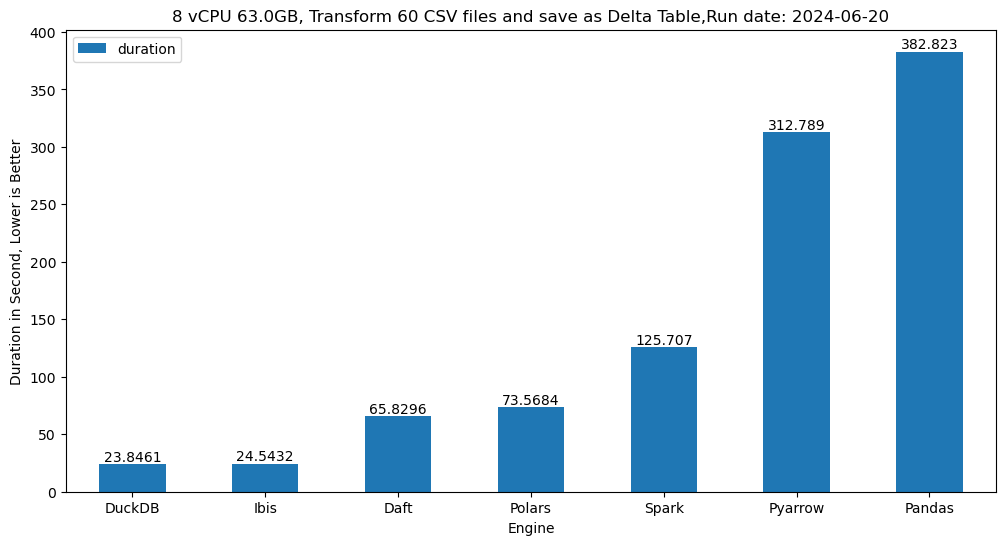

In [25]:
# @title
result = results.groupby(['Engine'])['duration'].sum().reset_index()
result = result.sort_values(by = ['duration'], ascending=[True])
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = vCPU+' '+str(mem)+'GB'+ ', Transform '+ str(total_files)+' CSV files and save as Delta Table,Run date: '+ str(time.strftime("%Y-%m-%d"))
ax = result.plot.bar(rot=0,x='Engine',title=runtime,ylabel='Duration in Second, Lower is Better',figsize=(12,6))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

# Check Size

In [26]:
# @title
#the function read all the tables in the default Lakehouse and save it in a Table Delta_stats, change the url to reflect your destination
import duckdb
import pandas as pd
from deltalake import DeltaTable
import os
from datetime import datetime
from deltalake.writer import write_deltalake
def get_stats(Source,Destination):
    appended_data = []
    List_tables = [ f.name for f in os.scandir(Source) if f.is_dir() ]
    stat_table = os.path.basename(os.path.normpath(Destination))
    if stat_table in List_tables: List_tables.remove(stat_table)
    for tbl in List_tables :
        dt = DeltaTable(Source+ tbl)
        xx= dt.get_add_actions(flatten=True).to_pandas()
        if 'tags.VORDER' in xx.columns:
             vorder =True
        else :
             vorder =False
        deltalog=pd.DataFrame([[tbl,xx['size_bytes'].sum(),vorder]],columns=['tbl','size_bytes','vorder'])
        delta = [Source+tbl + "/" + i for i in dt.files()]
        duckdb.sql(f'from parquet_scan({delta})').to_view(tbl)
        print(tbl)
        df= duckdb.sql(f'''
        with x as (
        select file_name,num_rows,num_row_groups, '{tbl}' as tbl from parquet_file_metadata({delta})
        )
        select x.tbl, file_name,num_rows,num_row_groups, ceil(size_bytes/(1024*1024)) as size,vorder from x
        left join deltalog as y
        on x.tbl=y.tbl
         ''').df()
        appended_data.append(df)
    appended_data = pd.concat(appended_data,ignore_index=True)
    appended_data['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    write_deltalake(Destination,appended_data,mode="overwrite",storage_options={"allow_unsafe_rename":"true"})

    dt = DeltaTable(Destination)
    delta = [Destination + "/" + i for i in dt.files()]
    duckdb.sql(f'from parquet_scan({delta})').to_view("xxx")

    duckdb.sql('''
    select tbl,
    sum(num_rows) as total_rows,
    count(*) as num_files,
    sum(num_row_groups) as num_row_group,
    cast(ceil(total_rows/num_row_group) as integer) as Average_row_group,
    min(size) as file_size_MB,
    vorder
    from xxx
    group by all
    order by file_size_MB ASC
    ''').show()
get_stats(table_root,raw_landing+'/xx_deltastats')

StatementMeta(, e0e9ff02-61c2-458d-9dcd-18cc72a3f9b7, 28, Finished, Available, Finished)

scada_Pandas
scada_DuckDB
scada_ibis
scada_Daft
scada_Pyarrow
scada_Polars
scada_spark
rr /lakehouse/default/Files/something/xx_deltastats/_delta_log/_commit_101eef0d-fa2b-4f34-87e2-757cd9302f04.json.tmp -> /lakehouse/default/Files/something/xx_deltastats/_delta_log/00000000000000000001.json
┌───────────────┬────────────┬───────────┬───────────────┬───────────────────┬──────────────┬─────────┐
│      tbl      │ total_rows │ num_files │ num_row_group │ Average_row_group │ file_size_MB │ vorder  │
│    varchar    │   int128   │   int64   │    int128     │       int32       │    double    │ boolean │
├───────────────┼────────────┼───────────┼───────────────┼───────────────────┼──────────────┼─────────┤
│ scada_spark   │    8453280 │         1 │             2 │           4226640 │         54.0 │ true    │
│ scada_Daft    │    8453280 │         1 │           129 │             65530 │         85.0 │ false   │
│ scada_DuckDB  │    8453280 │         1 │           128 │             66042 │     